In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE
import joblib

In [35]:
# 1. Muat data

df = pd.read_csv("diabetes.csv") # Memuat data csv
dataset = df.copy() # Copy dataset untuk pemrosesan

dataset.head() #enampilkan 5 baris pertama dari dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [36]:
# 2. Cek data
print("Dataset shape:", dataset.shape)
print("Jumlah duplikat:", dataset.duplicated().sum())
print("Missing values per kolom:\n", dataset.isnull().sum())

Dataset shape: (768, 9)
Jumlah duplikat: 0
Missing values per kolom:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [37]:
# 3. Pisahkan Fitur dan Label

X = dataset.drop(columns=["Outcome"])  # Semua kolom kecuali target
y = dataset["Outcome"]  # Kolom target

In [38]:
# 4. Split data

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [39]:
# 5. SMOTE (Oversampling hanya data training)

print("Distribusi sebelum SMOTE:\n", y_train.value_counts())
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Distribusi setelah SMOTE:\n", y_train_resampled.value_counts())


Distribusi sebelum SMOTE:
 Outcome
0    350
1    187
Name: count, dtype: int64
Distribusi setelah SMOTE:
 Outcome
1    350
0    350
Name: count, dtype: int64


In [40]:
# 6. standarisasi Data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


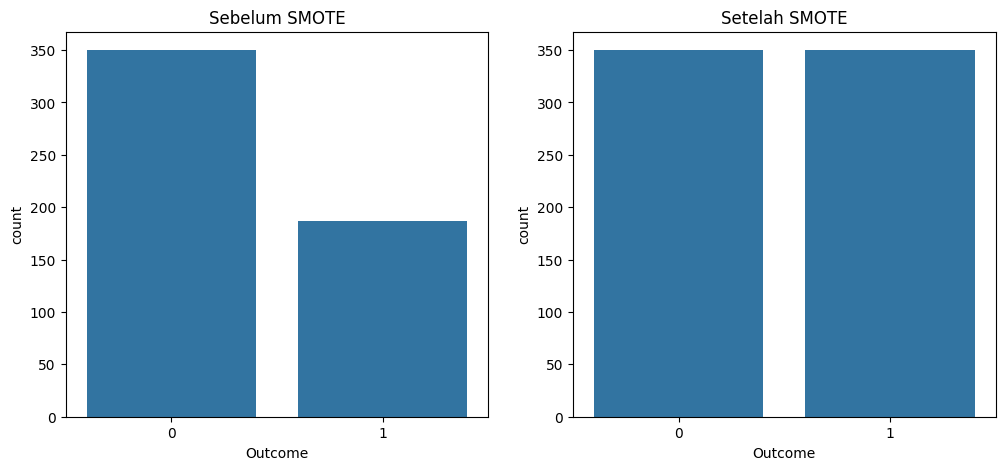

In [41]:
# Visualisasi distribusi label
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title("Sebelum SMOTE")
sns.countplot(x=y_train_resampled, ax=ax[1])
ax[1].set_title("Setelah SMOTE")
plt.show()

In [42]:
# 7. Random Forest + GridSearch
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=8,
    scoring='accuracy',
    refit=True
)


grid_rf.fit(X_train_scaled, y_train_resampled)

y_pred_rf = grid_rf.predict(X_test_scaled)



[Random Forest]
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.7835497835497836
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83       150
           1       0.68      0.72      0.70        81

    accuracy                           0.78       231
   macro avg       0.76      0.77      0.76       231
weighted avg       0.79      0.78      0.78       231



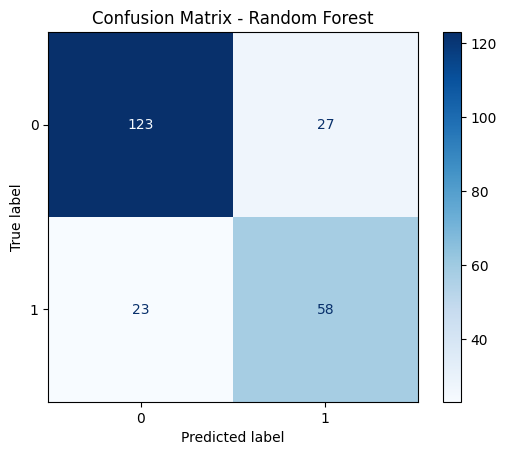

In [43]:
print("\n[Random Forest]")
print("Best Parameters:", grid_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [50]:
# 8. Simpan model, scaler, dan fitur
joblib.dump(grid_rf.best_estimator_, "model_diabetes.pkl")         # Model terbaik
joblib.dump(scaler, "scaler_diabetes.pkl")                         # Scaler hasil training

print("Model dan scaler berhasil disimpan.")


Model dan scaler berhasil disimpan.


In [53]:
# 9. Fungsi prediksi diabetes
def prediksi_diabetes(input_dict):
    """
    Memprediksi apakah pasien menderita diabetes berdasarkan input data.
    
    Parameters:
        input_dict (dict): Input data pasien (8 fitur)

    Returns:
        tuple: (label prediksi, probabilitas)
    """
    model = joblib.load("model_diabetes.pkl")
    scaler = joblib.load("scaler_diabetes.pkl")
    

    # Buat DataFrame dengan urutan kolom yang sesuai
    df_input = pd.DataFrame([input_dict], columns=fitur)

    # Standarisasi input
    scaled_input = scaler.transform(df_input)

    # Prediksi dan probabilitas
    prediksi = model.predict(scaled_input)[0]
    probabilitas = model.predict_proba(scaled_input)[0][prediksi]

    return prediksi, probabilitas


In [49]:
# 10. Contoh input data pasien
data_pasien = {
    "Pregnancies": 1,
    "Glucose": 85,
    "BloodPressure": 66,
    "SkinThickness": 29,
    "Insulin": 0,
    "BMI": 26.6,
    "DiabetesPedigreeFunction": 0.351,
    "Age": 31
}

# Panggil fungsi prediksi
label, prob = prediksi_diabetes(data_pasien)

# Cetak hasil prediksi
hasil = "Positif Diabetes" if label == 1 else "Negatif Diabetes"
print("\nHasil Prediksi:", hasil)
print(f"Probabilitas Keyakinan Model: {prob:.2%}")



Hasil Prediksi: Negatif Diabetes
Probabilitas Keyakinan Model: 93.68%
